## Due to the 100 MB size limit on GitHub, I separated the data cleaning processes into three notebooks:

* sf_crime_prediction.ipynb (main notebook)
* working_on_weather_data.ipynb
* working_on_flight_data.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import requests
import os
from io import StringIO
import json

import missingno as msno
import folium


from openai import OpenAI
from dotenv import load_dotenv
import re

from folium.plugins import MarkerCluster

pd.set_option('display.max_columns', None)

In [2]:
path = os.getcwd()
raw_data_path = path + "/../data/raw/"


In [3]:
# download our incident data and store in the raw data directory

base_url = "https://data.sfgov.org/resource/wg3w-h783.csv"
limit  = 1000
offset = 0
data  = []

df_incident = pd.DataFrame()

data_path = raw_data_path +'incident_raw.csv'

if not os.path.exists(data_path):
  while True:
    url = f"{base_url}?$limit={limit}&$offset={offset}"
    response = requests.get(url)
    if response.status_code == 200:
      if not offset%100000:
        print(f"Fetching data from {url}")
      batch_df = pd.read_csv(StringIO(response.text))
      if batch_df.empty:
        break
      df_incident = pd.concat([df_incident, batch_df], ignore_index=True)
      offset += limit
    else:
      print('Done!')
      break
  df_incident.to_csv(data_path)
  

In [4]:
# create dataframe
df_incident = pd.read_csv(data_path)

print(df_incident.info())
print("")
df_incident.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867964 entries, 0 to 867963
Data columns (total 35 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   Incident Datetime                                     867964 non-null  object 
 1   Incident Date                                         867964 non-null  object 
 2   Incident Time                                         867964 non-null  object 
 3   Incident Year                                         867964 non-null  int64  
 4   Incident Day of Week                                  867964 non-null  object 
 5   Report Datetime                                       867964 non-null  object 
 6   Row ID                                                867964 non-null  int64  
 7   Incident ID                                           867964 non-null  int64  
 8   Incident Number                             

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,Report Type Code,Report Type Description,Filed Online,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,Intersection,CNN,Police District,Analysis Neighborhood,Supervisor District,Supervisor District 2012,Latitude,Longitude,Point,Neighborhoods,ESNCAG - Boundary File,Central Market/Tenderloin Boundary Polygon - Updated,Civic Center Harm Reduction Project Boundary,HSOC Zones as of 2018-06-05,Invest In Neighborhoods (IIN) Areas,Current Supervisor Districts,Current Police Districts
0,2023/03/13 11:41:00 PM,2023/03/13,23:41,2023,Monday,2023/03/13 11:41:00 PM,125373607041,1253736,230167874,NaN,VS,Vehicle Supplement,NaN,7041,Recovered Vehicle,Recovered Vehicle,"Vehicle, Recovered, Auto",Open or Active,NaN,NaN,Out of SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023/03/01 05:02:00 AM,2023/03/01,05:02,2023,Wednesday,2023/03/11 03:40:00 PM,125379506374,1253795,236046151,NaN,II,Coplogic Initial,True,6374,Larceny Theft,Larceny Theft - Other,"Theft, Other Property, >$950",Open or Active,NaN,NaN,Mission,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023/03/13 01:16:00 PM,2023/03/13,13:16,2023,Monday,2023/03/13 01:17:00 PM,125357107041,1253571,220343896,NaN,VS,Vehicle Supplement,NaN,7041,Recovered Vehicle,Recovered Vehicle,"Vehicle, Recovered, Auto",Open or Active,NaN,NaN,Out of SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023/03/13 10:59:00 AM,2023/03/13,10:59,2023,Monday,2023/03/13 11:00:00 AM,125355107041,1253551,230174885,NaN,VS,Vehicle Supplement,NaN,7041,Recovered Vehicle,Recovered Vehicle,"Vehicle, Recovered, Auto",Open or Active,NaN,NaN,Out of SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023/03/14 06:44:00 PM,2023/03/14,18:44,2023,Tuesday,2023/03/14 06:45:00 PM,125402407041,1254024,230176728,NaN,VS,Vehicle Supplement,NaN,7041,Recovered Vehicle,Recovered Vehicle,"Vehicle, Recovered, Auto",Open or Active,NaN,NaN,Out of SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Metadata

<div class="schema-column-preview-table">
  <table class="forge-table">
    <thead>
      <tr>
        <th>Column Name</th>
        <th>Description</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>Incident Datetime</td>
        <td>The date and time when the incident occurred</td>
      </tr>
      <tr>
        <td>Incident Date</td>
        <td>The date the incident occurred</td>
      </tr>
      <tr>
        <td>Incident Time</td>
        <td>The time the incident occurred</td>
      </tr>
      <tr>
        <td>Incident Year</td>
        <td>The year the incident occurred, provided as a convenience for filtering</td>
      </tr>
      <tr>
        <td>Incident Day of Week</td>
        <td>The day of the week the incident occurred</td>
      </tr>
      <tr>
        <td>Report Datetime</td>
        <td>Distinct from Incident Datetime, Report Datetime is when the report was filed</td>
      </tr>
      <tr>
        <td>Row ID</td>
        <td>A unique identifier for each row of data in the dataset</td>
      </tr>
      <tr>
        <td>Incident ID</td>
        <td>This is the system generated identifier for incident reports</td>
      </tr>
      <tr>
        <td>Incident Number</td>
        <td>The number issued on the report, used to reference cases and report documents</td>
      </tr>
      <tr>
        <td>CAD Number</td>
        <td>The Computer Aided Dispatch (CAD) is the system used by the Department of Emergency Management to dispatch officers and other public safety personnel</td>
      </tr>
      <tr>
        <td>Report Type Code</td>
        <td>A system code for report types</td>
      </tr>
      <tr>
        <td>Report Type Description</td>
        <td>The description of the report type, such as Initial, Initial Supplement, Vehicle Initial, etc.</td>
      </tr>
      <tr>
        <td>Filed Online</td>
        <td>Indicates if the report was filed online by the public using SFPD’s self-service reporting system</td>
      </tr>
      <tr>
        <td>Incident Code</td>
        <td>System codes to describe a type of incident</td>
      </tr>
      <tr>
        <td>Incident Category</td>
        <td>A category mapped onto the Incident Code used in statistics and reporting</td>
      </tr>
      <tr>
        <td>Incident Subcategory</td>
        <td>A subcategory mapped to the Incident Code used for statistics and reporting</td>
      </tr>
      <tr>
        <td>Incident Description</td>
        <td>Description of the incident that corresponds with the Incident Code</td>
      </tr>
      <tr>
        <td>Resolution</td>
        <td>The resolution of the incident at the time of the report</td>
      </tr>
      <tr>
        <td>Intersection</td>
        <td>The 2 or more street names that intersect closest to the original incident</td>
      </tr>
      <tr>
        <td>CNN</td>
        <td>The unique identifier of the intersection for reference back to other related basemap datasets</td>
      </tr>
      <tr>
        <td>Police District</td>
        <td>The Police District where the incident occurred</td>
      </tr>
      <tr>
        <td>Analysis Neighborhood</td>
        <td>The neighborhood where each incident occurs</td>
      </tr>
      <tr>
        <td>Supervisor District</td>
        <td>Current Supervisor District</td>
      </tr>
      <tr>
        <td>Supervisor District 2012</td>
        <td>Previous 2012-2022 Supervisor District</td>
      </tr>
      <tr>
        <td>Latitude</td>
        <td>The latitude coordinate in WGS84</td>
      </tr>
      <tr>
        <td>Longitude</td>
        <td>The longitude coordinate in WGS84</td>
      </tr>
      <tr>
        <td>Point</td>
        <td>Geolocation in OGC WKT format</td>
      </tr>
    </tbody>
  </table>
</div>


In [5]:
# print the number of missing data for each column
df_isna = pd.DataFrame(df_incident.isna().sum(), columns=['missing_data'])
df_isna[df_isna['missing_data']!=0]

,missing_data
CAD Number,194284
Filed Online,695505
Incident Category,831
Incident Subcategory,831
Intersection,47694
CNN,47694
Analysis Neighborhood,47858
Supervisor District,48142
Supervisor District 2012,47835
Latitude,47694


In [6]:
del df_isna # no need to store extra data in the memory

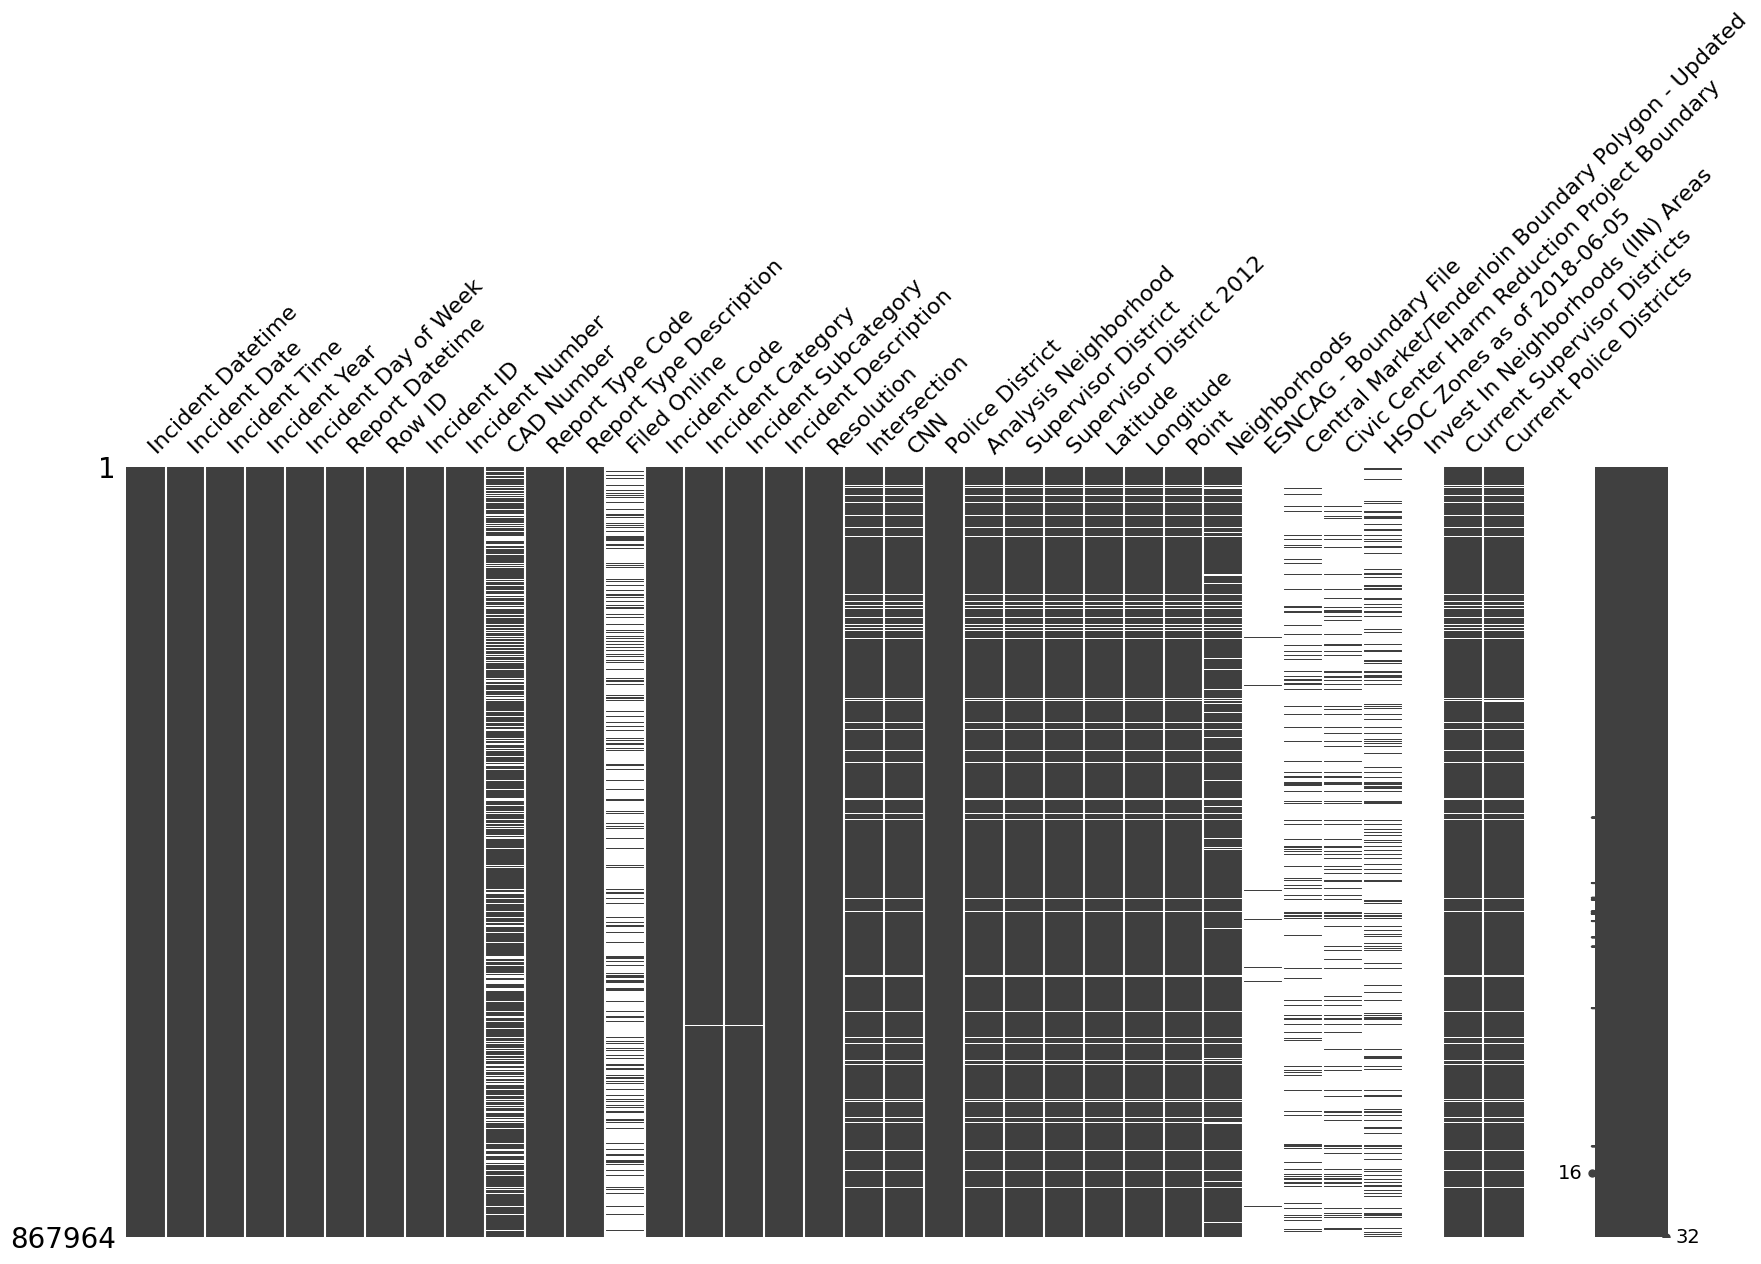

In [7]:
msno.matrix(df_incident.sort_values(by='Incident Datetime'), figsize=(20, 10))
plt.show()

### columns: 
* `ESNCAG - Boundary File` 
* `Central Market/Tenderloin Boundary Polygon - Updated` 
* `Civic Center Harm Reduction Project Boundary` 
* `HSOC Zones as of 2018-06-05`
* `Invest In Neighborhoods (IIN) Areas` 
### are pretty much empty columns, those columns will not help with any prediction.

## We can start cleaning our data with dropping those columns 


In [8]:
df_incident.drop(columns=['ESNCAG - Boundary File', 'Central Market/Tenderloin Boundary Polygon - Updated', 'Civic Center Harm Reduction Project Boundary', 'HSOC Zones as of 2018-06-05', 'Invest In Neighborhoods (IIN) Areas'], inplace=True)

In [9]:
msno.matrix(df_incident.sort_values(by='Incident Datetime'), figsize=(20, 10))
plt.show()

" msno.matrix(df_incident.sort_values(by='Incident Datetime'), figsize=(20, 10))\nplt.show() "

# Check for duplicates

In [10]:
# a basic check for duplicates with checking Date, id and incident code 
# Later we will see there are duplicates for incident ID, and we will figure out that mistery
duplicates = df_incident[['Incident Date', 'Incident ID',  'Incident Code']].duplicated(keep=False).sum()
print(f"There are {duplicates} duplicates in the dataframe.")

There are 0 duplicates in the dataframe.


# Which columns we will drop?
### Lets focus on the features we need for now!

### keep:
* Incident Date
* Incident Time
* Incident Day of Week
* Incident Category 
* Incident Subcategory 
* Incident Description
* Incident Code
* Incident ID
* Intersection 
* Latitude
* Longtitude
* Analysis Neighborhood
* Report type code
* report type description




In [11]:
df_incident  = df_incident.drop(columns=['Incident Datetime',  'Report Datetime', 'Row ID', 'Resolution', 'Report Type Code',	'Report Type Description','CNN', 'Police District', 'Supervisor District', 'Supervisor District 2012', 'Neighborhoods','Current Supervisor Districts', 'Current Police Districts', 'Point', 'Filed Online']).sort_values(by='Incident Date')

In [12]:
# `CAD Number` will not be helpful to our model and we can drop that column.
# Same for the 'Intersection'  we will continue with 'Analysis Neighborhood' column for location 

df_incident.drop(columns=['CAD Number', 'Intersection'], inplace=True)
df_incident.isna().sum()

Incident Date                0
Incident Time                0
Incident Year                0
Incident Day of Week         0
Incident ID                  0
Incident Number              0
Incident Code                0
Incident Category          831
Incident Subcategory       831
Incident Description         0
Analysis Neighborhood    47858
Latitude                 47694
Longitude                47694
dtype: int64

In [13]:
# Check for any incident codes that are present in both categories: 
# 1. Incident codes with missing 'Incident Category'
# 2. Incident codes with non-missing 'Incident Category'
df_incident[df_incident['Incident Code'].isin(set(df_incident[df_incident['Incident Category'].isna()]['Incident Code']))]['Incident Category'].notna().sum()

0

## There are some Incident categories is NaN and I wanted to check if corresponding Incident ID has any corresponding Incident Category not null. 
## But looks like there is none.  Look like we can fill these missing categories according to Incident  Description.

In [14]:
df_incident[df_incident['Incident Code'].isin(set(df_incident[df_incident['Incident Category'].isna()]['Incident Code']))]['Incident Code'].value_counts()

Incident Code
65021    313
27400    161
15410     85
7060      50
27401     50
15164     45
74020     29
64100     18
75011     12
6377      12
12075     10
65022      8
6378       6
6399       5
74024      4
15165      3
12020      3
74022      3
6353       3
12073      2
13072      2
6352       2
6354       1
4164       1
6351       1
9171       1
12004      1
Name: count, dtype: int64

In [15]:
df_incident[df_incident['Incident Code'].isin(set(df_incident[df_incident['Incident Category'].isna()]['Incident Code']))]['Incident Code'].value_counts().sum()

831

In [16]:
df_incident[df_incident['Incident Code'] == 65021]['Incident Category'].sum()

0

## After some exploaration I found out the incident codes above has no corresponding Incident category, and lets see what are the corresponding Incidinet Description 


In [17]:
descriptions_for_missing_categories = df_incident[df_incident['Incident Code'].isin(set(df_incident[df_incident['Incident Category'].isna()]['Incident Code']))]['Incident Description'].unique()
descriptions_for_missing_categories

array(['Military Ordinance', 'Auto Impounded',
       'Crimes Involving Receipts or Titles',
       'Procurement, Pimping, & Pandering',
       'Gun Violence Restraining Order',
       'Driving, Stunt Vehicle/Street Racing',
       'Assault, Commission of While Armed',
       'Public Health Order Violation, Notification',
       'Theft, Animal, Att.',
       'Public Health Order Violation, After Notification',
       'Pyrotechnic Explosive Device - Barrel Bomb',
       'Gun Violence Restraining Order Violation', 'Theft, Boat',
       'Service of Documents Related to a Civil Drug Abatement and/or Public Nuisance Action',
       'Cloned Cellular Phone, Use', 'Theft, Phone Booth, >$950',
       'SFMTA Parking and Control Officer', 'Assault, By Police Officers',
       'SFMTA Muni Transit Operator-Bus/LRV',
       'Cryptocurrency Related Crime (secondary code only)',
       'SFMTA Employee-Non Operator/Station Agent-Other Employee',
       'Theft, Phone Booth, $200-$950', 'Theft, Phone Boo

In [18]:
years_for_missing_categories = df_incident[df_incident['Incident Code'].isin(set(df_incident[df_incident['Incident Category'].isna()]['Incident Code']))]['Incident Date']
pd.to_datetime(years_for_missing_categories).dt.year.value_counts()
# I could not find any correlations between year and missing data at category

Incident Date
2020    302
2023    174
2021    150
2022    101
2024     92
2018     10
2019      2
Name: count, dtype: int64

In [19]:
for missing_description in descriptions_for_missing_categories:
    print(f"{missing_description}: ", end=" ")
    print(df_incident[(df_incident['Incident Description'] == missing_description) & (df_incident['Incident Category'].notna())].value_counts().sum())

Military Ordinance:  0
Auto Impounded:  0
Crimes Involving Receipts or Titles:  0
Procurement, Pimping, & Pandering:  0
Gun Violence Restraining Order:  0
Driving, Stunt Vehicle/Street Racing:  0
Assault, Commission of While Armed:  0
Public Health Order Violation, Notification:  0
Theft, Animal, Att.:  0
Public Health Order Violation, After Notification:  0
Pyrotechnic Explosive Device - Barrel Bomb:  0
Gun Violence Restraining Order Violation:  0
Theft, Boat:  4
Service of Documents Related to a Civil Drug Abatement and/or Public Nuisance Action:  0
Cloned Cellular Phone, Use:  0
Theft, Phone Booth, >$950:  0
SFMTA Parking and Control Officer:  0
Assault, By Police Officers:  0
SFMTA Muni Transit Operator-Bus/LRV:  0
Cryptocurrency Related Crime (secondary code only):  0
SFMTA Employee-Non Operator/Station Agent-Other Employee:  0
Theft, Phone Booth, $200-$950:  0
Theft, Phone Booth, $50-$200:  0
Theft, Phone Booth, <$50:  0
Vehicle, Seizure Order:  0
Vehicle, Seizure Order Service: 

### `Theft, Boat` from description is the only one has been in a category before.
### Lets see what is that category:

In [20]:
df_incident[df_incident['Incident Description']=='Theft, Boat']

,Incident Date,Incident Time,Incident Year,Incident Day of Week,Incident ID,Incident Number,Incident Code,Incident Category,Incident Subcategory,Incident Description,Analysis Neighborhood,Latitude,Longitude
529965,2018/09/22,04:25,2018,Saturday,717443,180718632,6375,Larceny Theft,Larceny Theft - Other,"Theft, Boat",Tenderloin,37.778719,-122.414741
748110,2019/07/07,12:00,2019,Sunday,827140,190543902,6375,Larceny Theft,Larceny Theft - Other,"Theft, Boat",Financial District/South Beach,37.800896,-122.399130
831861,2020/05/30,02:17,2020,Saturday,931242,200326470,6377,NaN,NaN,"Theft, Boat",Sunset/Parkside,37.760898,-122.495213
812119,2020/06/28,17:00,2020,Sunday,939400,200388470,6377,NaN,NaN,"Theft, Boat",Financial District/South Beach,37.781798,-122.388306
824649,2020/06/28,17:00,2020,Sunday,939406,200388486,6377,NaN,NaN,"Theft, Boat",Financial District/South Beach,37.781798,-122.388306
777457,2020/06/28,17:00,2020,Sunday,939395,200388464,6377,NaN,NaN,"Theft, Boat",Financial District/South Beach,37.781798,-122.388306
764599,2020/06/28,17:00,2020,Sunday,939365,200388458,6377,NaN,NaN,"Theft, Boat",Financial District/South Beach,37.781798,-122.388306
809093,2020/06/30,10:30,2020,Tuesday,939678,200388458,6375,Larceny Theft,Larceny Theft - Other,"Theft, Boat",Financial District/South Beach,37.781798,-122.388306
797975,2020/06/30,10:30,2020,Tuesday,939677,200388464,6375,Larceny Theft,Larceny Theft - Other,"Theft, Boat",Financial District/South Beach,37.781798,-122.388306
808552,2020/09/28,14:30,2020,Monday,968057,200608955,6377,NaN,NaN,"Theft, Boat",Financial District/South Beach,37.781798,-122.388306


### We can change Incident code to 'Larceny Theft' for corresponding to  where 'Incident Description" is 'Theft, Boat. 

In [21]:
df_incident.loc[df_incident['Incident Description']=='Theft, Boat',['Incident Category', 'Incident Subcategory']] = 'Larceny Theft'


## For the remaining missing data, I will use AI (OpenAI) to classify the corresponding Incident Category.

In [22]:
load_dotenv()

client = OpenAI(api_key=str(os.getenv('OPENAI_API_KEY')))


model = 'gpt-4o'

instructions = f"""You will receive a list of crime descriptions, and you will find the best possible corresponding categories from 
{set(df_incident[df_incident['Incident Category'].notnull()]['Incident Category'])}.
Your response should be in the format of a Python dictionary with description:category pairs. with not using new line, just one line"""

def get_comtpetion(prompt, model=model, instruction=instructions):
    message=[{'role':'system', 'content':instruction}, 
             {'role':'user', 'content':prompt}]
    response=client.chat.completions.create(
        model=model,
        messages=message,
        temperature = 1,
        
    )
    return response.choices[0].message.content

missing_descriptions = set(df_incident[df_incident['Incident Code'].isin(set(df_incident[df_incident['Incident Category'].isna()]['Incident Code']))]['Incident Description'])



text_dict = get_comtpetion(f"Here are the descriptions for you: {list(missing_descriptions)}")

match = re.search(r"\{(.*?)\}", text_dict.strip(), re.DOTALL) 
if match:
    dict_text = '{'+match.group(1)+'}'
else:
    print('No match')


In [23]:
description_to_category =eval(dict_text)
for key, value in description_to_category.items():
    df_incident.loc[df_incident['Incident Description'] == key , ['Incident Category', 'Incident Subcategory']] = value

df_incident.isna().sum()    

Incident Date                0
Incident Time                0
Incident Year                0
Incident Day of Week         0
Incident ID                  0
Incident Number              0
Incident Code                0
Incident Category            0
Incident Subcategory         0
Incident Description         0
Analysis Neighborhood    47858
Latitude                 47694
Longitude                47694
dtype: int64

## Let's Fill Empty Cells in Latitude, Longitude, and 'Analysis Neighborhood' Columns

### My Plan:

1. **Filling 'Analysis Neighborhood':**
   - Start by filling the 'Analysis Neighborhood' column with the mode (most frequent) neighborhood for the corresponding incident category.

2. **Filling Latitude and Longitude:**
   - Fill the Latitude and Longitude columns with the mean values of their respective groups, grouped by the first neighborhood and incident category.


In [24]:

mode_neighborhoods = df_incident.groupby('Incident Category')['Analysis Neighborhood'].agg(lambda x: x.mode()[0])

cat_neig = mode_neighborhoods.to_dict()


for index, row in df_incident.iterrows():
    if pd.isna(row['Analysis Neighborhood']):
        df_incident.loc[index, 'Analysis Neighborhood'] = cat_neig[row['Incident Category']]
        
   

In [25]:
df_incident['Latitude'] = df_incident.groupby('Analysis Neighborhood')['Latitude'].transform(lambda x: x.fillna(x.mean()))
df_incident['Longitude'] = df_incident.groupby('Analysis Neighborhood')['Longitude'].transform(lambda x: x.fillna(x.mean()))

In [26]:
df_incident.isna().sum()

Incident Date            0
Incident Time            0
Incident Year            0
Incident Day of Week     0
Incident ID              0
Incident Number          0
Incident Code            0
Incident Category        0
Incident Subcategory     0
Incident Description     0
Analysis Neighborhood    0
Latitude                 0
Longitude                0
dtype: int64

In [27]:
# finally fix the data type for 'Incident Date' 
df_incident['Incident Date'] = pd.to_datetime(df_incident['Incident Date'])

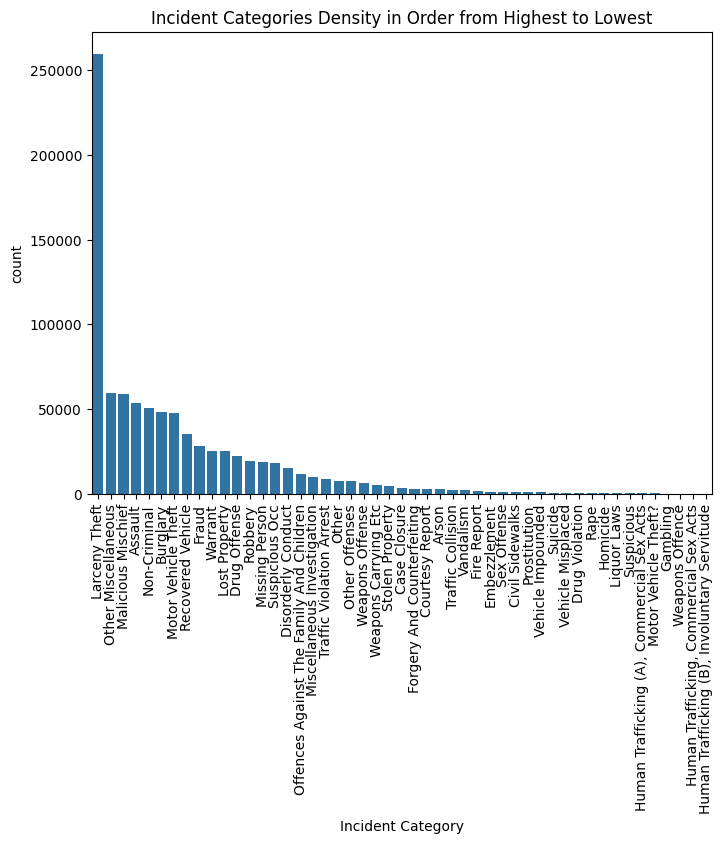

In [28]:
plt.figure(figsize=(8,6))
category_counts = df_incident['Incident Category'].value_counts()
sorted_categories = category_counts.index.to_list()
sns.countplot(data=df_incident,
             x='Incident Category', order=sorted_categories)
plt.title("Incident Categories Density in Order from Highest to Lowest")
plt.xticks(rotation=90)
plt.show();


## There are too many different Incident categories which are not being so helpful. I will focus on that later

In [29]:
# lets check consistincy
df_incident[df_incident['Incident Description'] == 'Battery']['Incident Category'].value_counts()

Incident Category
Assault    26416
Name: count, dtype: int64

## Lets merge our dataframes (df_incident & df_weather)

In [30]:
df_weather = pd.read_csv(path + "/../data/processed/sf_weather_processed.csv")
df_weather['DATE']= pd.to_datetime(df_weather['DATE'], format="%Y-%m-%d")



In [31]:
# we will merge our data on date coumns

df_incident = pd.merge(df_incident, df_weather, left_on='Incident Date', right_on='DATE', how='left')

In [32]:
del df_weather
df_incident = df_incident.drop(columns=['DATE'])
df_incident.head()

,Incident Date,Incident Time,Incident Year,Incident Day of Week,Incident ID,Incident Number,Incident Code,Incident Category,Incident Subcategory,Incident Description,Analysis Neighborhood,Latitude,Longitude,PRCP,TMIN,TMAX
0,2018-01-01,08:54,2018,Monday,620134,180002786,9320,Fraud,Fraud,"Access Card, incl. Credit, Phone, ATM, Fraudul...",Portola,37.728915,-122.413971,0.0,48.0,61.0
1,2018-01-01,00:00,2018,Monday,764041,190059824,10025,Embezzlement,Embezzlement,"Embezzlement, Grand Theft By Brokers/Agents",Chinatown,37.798442,-122.409879,0.0,48.0,61.0
2,2018-01-01,01:30,2018,Monday,618937,180000257,4136,Assault,Simple Assault,Battery with Serious Injuries,Financial District/South Beach,37.793664,-122.396390,0.0,48.0,61.0
3,2018-01-01,06:00,2018,Monday,794793,190297024,9024,Fraud,Fraud,"Fraudulent Game or Trick, Obtaining Money or P...",Bayview Hunters Point,37.733373,-122.382030,0.0,48.0,61.0
4,2018-01-01,18:48,2018,Monday,619934,186001940,6244,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, >$950",Western Addition,37.780373,-122.440589,0.0,48.0,61.0


## Lets rename our columns for consistency.

In [33]:
df_incident.rename(columns={
    'Incident Date': 'incident_date',
    'Incident Time': 'incident_time',
    'Incident Year': 'incident_year',
    'Incident Day of Week': 'incident_day',
    'Incident ID': 'incident_id',
    'Incident Number': 'incident_no',
    'Incident Code': 'incident_code',
    'Incident Category': 'category',
    'Incident Subcategory': 'subcategory',
    'Incident Description': 'description',
    'Analysis Neighborhood': 'neighborhood',
    'Latitude': 'latitude',
    'Longitude': 'longitude',
    'PRCP': 'precipitation',
    'TMIN': 'min_temperature',
    'TMAX': 'max_temperature'
}, inplace=True)

df_incident.head(1)

,incident_date,incident_time,incident_year,incident_day,incident_id,incident_no,incident_code,category,subcategory,description,neighborhood,latitude,longitude,precipitation,min_temperature,max_temperature
0,2018-01-01,08:54,2018,Monday,620134,180002786,9320,Fraud,Fraud,"Access Card, incl. Credit, Phone, ATM, Fraudul...",Portola,37.728915,-122.413971,0.0,48.0,61.0


## Looks good! Now time to get our flight data!

In [34]:
df_flight = pd.read_csv(path+"/../data/processed/flight_processed.csv")
df_flight['activity_period'] = pd.to_datetime(df_flight['activity_period'], format="%Y-%m-%d")

# Merge flight data

In [35]:
df_incident = df_incident.merge(df_flight, left_on='incident_date', right_on='activity_period', how='left')
del df_flight

In [36]:
df_incident[['activity_period','deplaned_passenger','enplaned_passenger']] = df_incident[['activity_period','deplaned_passenger','enplaned_passenger']].ffill()

In [37]:
df_incident.isna().sum()

incident_date           0
incident_time           0
incident_year           0
incident_day            0
incident_id             0
incident_no             0
incident_code           0
category                0
subcategory             0
description             0
neighborhood            0
latitude                0
longitude               0
precipitation         964
min_temperature       964
max_temperature       964
activity_period         0
deplaned_passenger      0
enplaned_passenger      0
dtype: int64

In [38]:
# we have missing data on weather related columns Lets see what are the corresponding dates to those

df_incident[df_incident['precipitation'].isna()]['incident_date'].value_counts()

incident_date
2018-02-28    441
2024-07-08    213
2024-07-07    184
2024-07-09    126
Name: count, dtype: int64

### We only have data missing for 4 days related to weather. It will be acceptable to fill these cells with data from earlier days, as the weather conditions are likely to be quite similar.

In [39]:
df_incident.ffill(inplace=True)

In [40]:
df_incident.drop(columns='activity_period', inplace=True)
df_incident.head()

,incident_date,incident_time,incident_year,incident_day,incident_id,incident_no,incident_code,category,subcategory,description,neighborhood,latitude,longitude,precipitation,min_temperature,max_temperature,deplaned_passenger,enplaned_passenger
0,2018-01-01,08:54,2018,Monday,620134,180002786,9320,Fraud,Fraud,"Access Card, incl. Credit, Phone, ATM, Fraudul...",Portola,37.728915,-122.413971,0.0,48.0,61.0,2172552.0,2016637.0
1,2018-01-01,00:00,2018,Monday,764041,190059824,10025,Embezzlement,Embezzlement,"Embezzlement, Grand Theft By Brokers/Agents",Chinatown,37.798442,-122.409879,0.0,48.0,61.0,2172552.0,2016637.0
2,2018-01-01,01:30,2018,Monday,618937,180000257,4136,Assault,Simple Assault,Battery with Serious Injuries,Financial District/South Beach,37.793664,-122.396390,0.0,48.0,61.0,2172552.0,2016637.0
3,2018-01-01,06:00,2018,Monday,794793,190297024,9024,Fraud,Fraud,"Fraudulent Game or Trick, Obtaining Money or P...",Bayview Hunters Point,37.733373,-122.382030,0.0,48.0,61.0,2172552.0,2016637.0
4,2018-01-01,18:48,2018,Monday,619934,186001940,6244,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, >$950",Western Addition,37.780373,-122.440589,0.0,48.0,61.0,2172552.0,2016637.0


In [41]:
df_incident.isna().sum()

incident_date         0
incident_time         0
incident_year         0
incident_day          0
incident_id           0
incident_no           0
incident_code         0
category              0
subcategory           0
description           0
neighborhood          0
latitude              0
longitude             0
precipitation         0
min_temperature       0
max_temperature       0
deplaned_passenger    0
enplaned_passenger    0
dtype: int64

## Perfect! We merged all there tables and we handled all the missing datas.

## Now we need to work on incidents. Many incidents consist of multiple sub-incidents. We need to filter these incidents into one main incident category.

In [42]:
df_incident[df_incident['incident_id'].duplicated(keep=False)][['incident_id', 'category', 'subcategory']].sort_values('incident_id').head(50)

,incident_id,category,subcategory
234,618691,Offences Against The Family And Children,Other
406,618691,Assault,Simple Assault
251,618701,Other Miscellaneous,Other
237,618701,Traffic Violation Arrest,Traffic Violation Arrest
166,618701,Vehicle Impounded,Vehicle Impounded
270,618709,Assault,Simple Assault
13,618709,Malicious Mischief,Vandalism
273,618710,Assault,Simple Assault
470,618710,Larceny Theft,Theft From Vehicle
34,618710,Assault,Aggravated Assault


In [43]:
sorted(list(df_incident['category'].unique()))

['Arson',
 'Assault',
 'Burglary',
 'Case Closure',
 'Civil Sidewalks',
 'Courtesy Report',
 'Disorderly Conduct',
 'Drug Offense',
 'Drug Violation',
 'Embezzlement',
 'Fire Report',
 'Forgery And Counterfeiting',
 'Fraud',
 'Gambling',
 'Homicide',
 'Human Trafficking (A), Commercial Sex Acts',
 'Human Trafficking (B), Involuntary Servitude',
 'Human Trafficking, Commercial Sex Acts',
 'Larceny Theft',
 'Liquor Laws',
 'Lost Property',
 'Malicious Mischief',
 'Miscellaneous Investigation',
 'Missing Person',
 'Motor Vehicle Theft',
 'Motor Vehicle Theft?',
 'Non-Criminal',
 'Offences Against The Family And Children',
 'Other',
 'Other Miscellaneous',
 'Other Offenses',
 'Prostitution',
 'Rape',
 'Recovered Vehicle',
 'Robbery',
 'Sex Offense',
 'Stolen Property',
 'Suicide',
 'Suspicious',
 'Suspicious Occ',
 'Traffic Collision',
 'Traffic Violation Arrest',
 'Vandalism',
 'Vehicle Impounded',
 'Vehicle Misplaced',
 'Warrant',
 'Weapons Carrying Etc',
 'Weapons Offence',
 'Weapons Of

### There is the same category, but with different British and American spellings: 'Weapons Offence' versus 'Weapons Offense.'

In [44]:
df_incident.loc[df_incident['category']=='Weapons Offense', 'category'] = 'Weapons Offence'

### There are some categories I want to see their description to understand better. 

In [45]:
df_incident[(df_incident['category'].isin(['Suspicious','Suspicious Occ'])) & \
    ~(df_incident['description'].isin(['Suspicious Occurrence','Suspicious Vehicle' ,'Suspicious Person','Suspicious Act Towards Female']) )]\
        [['subcategory', 'description']]

,subcategory,description
11384,Suspicious Occ,"Suspicious Occurrence, possible Shots Fired"
11678,Suspicious Occ,"Suspicious Occurrence, possible Shots Fired"
13356,Suspicious Package,Suspicious Package
17490,Suspicious Occ,"Suspicious Occurrence, possible Shots Fired"
31324,Suspicious Occ,"Suspicious Occurrence, possible Shots Fired"
...,...,...
858655,Suspicious Package,Suspicious Package
858903,Suspicious Occ,"Suspicious Occurrence, possible Shots Fired"
859186,Suspicious Package,Suspicious Package
866447,Suspicious Package,Suspicious Package


In [46]:
df_incident[df_incident['category']=='Other Offenses']['description']

62                       License Plate, Lost
204                     License Plate, Found
838                 License Plate, Recovered
839       Obstructions On Streets, Sidewalks
1006           Park Code Violation (general)
                         ...                
867501                  License Plate, Found
867520              License Plate, Recovered
867885              License Plate, Recovered
867902               Taxi Fare, Overcharging
867949              License Plate, Recovered
Name: description, Length: 7459, dtype: object

## Firsty I will drop the rows has crimes has no require immidiate police attention or no police attention at all

In [47]:
df_incident = df_incident[(~df_incident['category'].isin(['Case Closure', 'Non-Criminal' , 'Offences Against The Family And Children','Courtesy Report', 'Fire Report','Recovered Vehicle'
                                          ,'Warrant', 'Liquor Laws', 'Other Miscellaneous', 'Gambling', 'Other', 'Missing Person', \
                                              'Civil Sidewalks', 'Traffic Collision', 'Suicide','Suspicious','Suspicious Occ', 'Other Offenses']))]

In [48]:
sorted(list(df_incident['category'].unique()))

['Arson',
 'Assault',
 'Burglary',
 'Disorderly Conduct',
 'Drug Offense',
 'Drug Violation',
 'Embezzlement',
 'Forgery And Counterfeiting',
 'Fraud',
 'Homicide',
 'Human Trafficking (A), Commercial Sex Acts',
 'Human Trafficking (B), Involuntary Servitude',
 'Human Trafficking, Commercial Sex Acts',
 'Larceny Theft',
 'Lost Property',
 'Malicious Mischief',
 'Miscellaneous Investigation',
 'Motor Vehicle Theft',
 'Motor Vehicle Theft?',
 'Prostitution',
 'Rape',
 'Robbery',
 'Sex Offense',
 'Stolen Property',
 'Traffic Violation Arrest',
 'Vandalism',
 'Vehicle Impounded',
 'Vehicle Misplaced',
 'Weapons Carrying Etc',
 'Weapons Offence']

## Let's see crime distribution on map

In [49]:
def find_on_map_with_category(cat_type):
    sf_map= folium.Map(location=[37.7749, -122.4194], zoom_start=12)

    marker_cluster = MarkerCluster().add_to(sf_map)
    
    for i, row in df_incident.loc[df_incident['category']==cat_type].iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=row['incident_date'].strftime('%B %d,%Y')
        ).add_to(marker_cluster)
    display(sf_map)


" def find_on_map_with_category(cat_type):\n    sf_map= folium.Map(location=[37.7749, -122.4194], zoom_start=12)\n\n    marker_cluster = MarkerCluster().add_to(sf_map)\n    \n    for i, row in df_incident.loc[df_incident['category']==cat_type].iterrows():\n        folium.Marker(\n            location=[row['latitude'], row['longitude']],\n            popup=row['incident_date'].strftime('%B %d,%Y')\n        ).add_to(marker_cluster)\n    display(sf_map)\n"

In [50]:
display(df_incident[(df_incident['category']=='Malicious Mischief') & (df_incident['subcategory']=='Other')][['subcategory', 'description']])
df_incident[df_incident['category']=='Malicious Mischief'][['subcategory']].value_counts()

,subcategory,description
90,Other,"Phone Calls, Harassing"
350,Other,"Phone Calls, Harassing"
354,Other,"Phone Calls, Harassing"
360,Other,"Phone Calls, Harassing"
495,Other,"Phone Calls, Harassing"
...,...,...
866601,Other,"Phone Calls, Harassing"
866814,Other,"Animal, Cruelty to"
866922,Other,"Phone Calls, Harassing"
867511,Other,"Animal, Cruelty to"


subcategory
Vandalism      56353
Other           2321
Name: count, dtype: int64

### Looks like we can Change `Malicious Mischief` to `Vandalism` after droping wher subcategory is Other

In [51]:
df_incident.shape

(623608, 18)

In [52]:
df_incident = df_incident[~((df_incident['category']=='Malicious Mischief') & (df_incident['subcategory']=='Other'))]
df_incident.loc[df_incident['category']=='Malicious Mischief', 'category'] = 'Vandalism'

In [68]:
def find_on_map_with_subcategory(cat_type):
    sf_map= folium.Map(location=[37.7749, -122.4194], zoom_start=12)

    marker_cluster = MarkerCluster().add_to(sf_map)
    
    for i, row in df_incident.loc[df_incident['subcategory']==cat_type].iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=row['incident_date'].strftime('%B %d,%Y')
        ).add_to(marker_cluster)
    return(sf_map)
    
sf_map =find_on_map_with_subcategory('Larceny - From Vehicle')
sf_map.save('larceny_from_vehicle_on_map.html')

### Wow! That is more than what I expected, I hope our prediction model will work!

In [54]:
sorted_categories = df_incident['category'].value_counts().index.to_list()
sorted_categories

['Larceny Theft',
 'Vandalism',
 'Assault',
 'Burglary',
 'Motor Vehicle Theft',
 'Fraud',
 'Lost Property',
 'Drug Offense',
 'Robbery',
 'Disorderly Conduct',
 'Miscellaneous Investigation',
 'Traffic Violation Arrest',
 'Weapons Offence',
 'Weapons Carrying Etc',
 'Stolen Property',
 'Forgery And Counterfeiting',
 'Arson',
 'Embezzlement',
 'Sex Offense',
 'Prostitution',
 'Vehicle Impounded',
 'Vehicle Misplaced',
 'Drug Violation',
 'Rape',
 'Homicide',
 'Human Trafficking (A), Commercial Sex Acts',
 'Motor Vehicle Theft?',
 'Human Trafficking, Commercial Sex Acts',
 'Human Trafficking (B), Involuntary Servitude']

In [55]:
df_incident.info()

<class 'pandas.core.frame.DataFrame'>
Index: 621287 entries, 0 to 867962
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   incident_date       621287 non-null  datetime64[ns]
 1   incident_time       621287 non-null  object        
 2   incident_year       621287 non-null  int64         
 3   incident_day        621287 non-null  object        
 4   incident_id         621287 non-null  int64         
 5   incident_no         621287 non-null  int64         
 6   incident_code       621287 non-null  int64         
 7   category            621287 non-null  object        
 8   subcategory         621287 non-null  object        
 9   description         621287 non-null  object        
 10  neighborhood        621287 non-null  object        
 11  latitude            621287 non-null  float64       
 12  longitude           621287 non-null  float64       
 13  precipitation       621287 non-nul

In [56]:
df_incident.head()

,incident_date,incident_time,incident_year,incident_day,incident_id,incident_no,incident_code,category,subcategory,description,neighborhood,latitude,longitude,precipitation,min_temperature,max_temperature,deplaned_passenger,enplaned_passenger
0,2018-01-01,08:54,2018,Monday,620134,180002786,9320,Fraud,Fraud,"Access Card, incl. Credit, Phone, ATM, Fraudul...",Portola,37.728915,-122.413971,0.0,48.0,61.0,2172552.0,2016637.0
1,2018-01-01,00:00,2018,Monday,764041,190059824,10025,Embezzlement,Embezzlement,"Embezzlement, Grand Theft By Brokers/Agents",Chinatown,37.798442,-122.409879,0.0,48.0,61.0,2172552.0,2016637.0
2,2018-01-01,01:30,2018,Monday,618937,180000257,4136,Assault,Simple Assault,Battery with Serious Injuries,Financial District/South Beach,37.793664,-122.396390,0.0,48.0,61.0,2172552.0,2016637.0
3,2018-01-01,06:00,2018,Monday,794793,190297024,9024,Fraud,Fraud,"Fraudulent Game or Trick, Obtaining Money or P...",Bayview Hunters Point,37.733373,-122.382030,0.0,48.0,61.0,2172552.0,2016637.0
4,2018-01-01,18:48,2018,Monday,619934,186001940,6244,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, >$950",Western Addition,37.780373,-122.440589,0.0,48.0,61.0,2172552.0,2016637.0


In [57]:
# all the day name matches with the actual date
(~(df_incident['incident_day'] == df_incident['incident_date'].dt.day_name())).sum()

0

In [58]:
df_incident['category'] = pd.Categorical(df_incident['category'], categories=sorted_categories, ordered=True)
df_incident['subcategory'] = pd.Categorical(df_incident['subcategory'])


In [59]:
df_incident.shape

(621287, 18)

In [60]:
df_incident = df_incident.sort_values(by=['incident_id', 'category'])
df_incident.drop_duplicates(subset='incident_id', keep='first', inplace=True)
df_incident.shape


(560138, 18)

In [61]:
df_incident.sort_values(by='incident_date', inplace=True)
df_incident.drop(columns=['incident_id', 'incident_code'], inplace=True)
print(df_incident.shape)
df_incident.head()

(560138, 16)


,incident_date,incident_time,incident_year,incident_day,incident_no,category,subcategory,description,neighborhood,latitude,longitude,precipitation,min_temperature,max_temperature,deplaned_passenger,enplaned_passenger
406,2018-01-01,00:55,2018,Monday,180000172,Assault,Simple Assault,Battery,Mission,37.768473,-122.405828,0.0,48.0,61.0,2172552.0,2016637.0
81,2018-01-01,16:30,2018,Monday,186000005,Vandalism,Vandalism,"Malicious Mischief, Vandalism to Property",Mission,37.761268,-122.416797,0.0,48.0,61.0,2172552.0,2016637.0
164,2018-01-01,19:30,2018,Monday,186017113,Lost Property,Lost Property,Lost Property,Financial District/South Beach,37.789241,-122.400722,0.0,48.0,61.0,2172552.0,2016637.0
243,2018-01-01,19:00,2018,Monday,180002225,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, >$950",Russian Hill,37.802201,-122.417966,0.0,48.0,61.0,2172552.0,2016637.0
420,2018-01-01,22:00,2018,Monday,180017064,Lost Property,Lost Property,Lost Property,Castro/Upper Market,37.760889,-122.435001,0.0,48.0,61.0,2172552.0,2016637.0


In [62]:
profile = ProfileReport(df_incident, title="Profiling Report")

' profile = ProfileReport(df_incident, title="Profiling Report") '

In [63]:
profile.to_file('sf_crime_clean_data_report.html')

" profile.to_file('sf_crime_clean_data_report.html' "

In [64]:
columns = df_incident.columns.to_list()
data_types = [df_incident[column].dtypes.name for column in columns]
data_type_dict = dict(zip(columns, data_types))

In [65]:
df_incident.reset_index(drop=True, inplace=True)
df_incident.head()

,incident_date,incident_time,incident_year,incident_day,incident_no,category,subcategory,description,neighborhood,latitude,longitude,precipitation,min_temperature,max_temperature,deplaned_passenger,enplaned_passenger
0,2018-01-01,00:55,2018,Monday,180000172,Assault,Simple Assault,Battery,Mission,37.768473,-122.405828,0.0,48.0,61.0,2172552.0,2016637.0
1,2018-01-01,16:30,2018,Monday,186000005,Vandalism,Vandalism,"Malicious Mischief, Vandalism to Property",Mission,37.761268,-122.416797,0.0,48.0,61.0,2172552.0,2016637.0
2,2018-01-01,19:30,2018,Monday,186017113,Lost Property,Lost Property,Lost Property,Financial District/South Beach,37.789241,-122.400722,0.0,48.0,61.0,2172552.0,2016637.0
3,2018-01-01,19:00,2018,Monday,180002225,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, >$950",Russian Hill,37.802201,-122.417966,0.0,48.0,61.0,2172552.0,2016637.0
4,2018-01-01,22:00,2018,Monday,180017064,Lost Property,Lost Property,Lost Property,Castro/Upper Market,37.760889,-122.435001,0.0,48.0,61.0,2172552.0,2016637.0


In [66]:
df_incident.to_csv(path+'/../data/interim/sf_crime_cleaned.csv', index=False)

In [67]:
with open(path+'/../data/interim/sf_incident_dtypes.json', 'w') as f:
    json.dump(data_type_dict, f)